In [1]:
from fastai.vision.all import *

In [ ]:
import os

In [49]:
files = get_image_files("subset")
len(files)
# files
os.getcwd()+"/subset"

'C:\\Users\\magnu\\OneDrive\\Dokumente\\Datathon_2022/subset'

In [94]:
import pandas as pd
N_FILES = 50000

df_eval = pd.read_csv("eval_data_public.csv")
df_train = pd.read_csv("train_data.csv")
df_att = pd.read_csv("list_attr_celeba.csv").set_index("image_id")
df_att = df_att.replace({-1:0})

s_eval = df_eval.set_index("id")["16_image_ids"]
df_train = df_train.set_index("id")[["16_image_ids","anomalous_image_id","attributes"]]
for col in columns:
    df_att[col] = df_att[col].apply(bool)
df_att.columns

Index(['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes',
       'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair',
       'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin',
       'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones',
       'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard',
       'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline',
       'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair',
       'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick',
       'Wearing_Necklace', 'Wearing_Necktie', 'Young'],
      dtype='object')

In [98]:
path = "all_images/img_align_celeba"
df = pd.DataFrame.from_dict({"name": list(df_att.index)[:N_FILES], "labels": list(df_att['Arched_Eyebrows'])[:N_FILES]})
df
dls = ImageDataLoaders.from_df(df, path)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


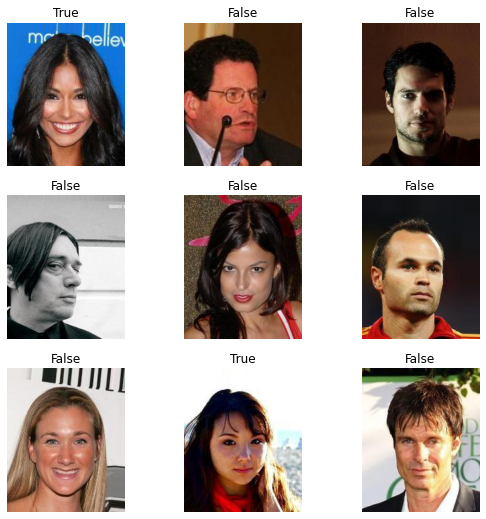

In [99]:
dls.show_batch()

In [100]:
learn = vision_learner(dls, weights=ResNet18_Weights.DEFAULT, metrics=error_rate, lr = 0.01)
learn.fine_tune(3)

C:\Users\magnu\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
C:\Users\magnu\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,0.490369,0.435632,0.218000,03:04


epoch,train_loss,valid_loss,error_rate,time
0,0.357876,0.346058,0.163200,02:34
1,0.322975,0.330515,0.154800,02:38
2,0.184051,0.392993,0.155700,02:38


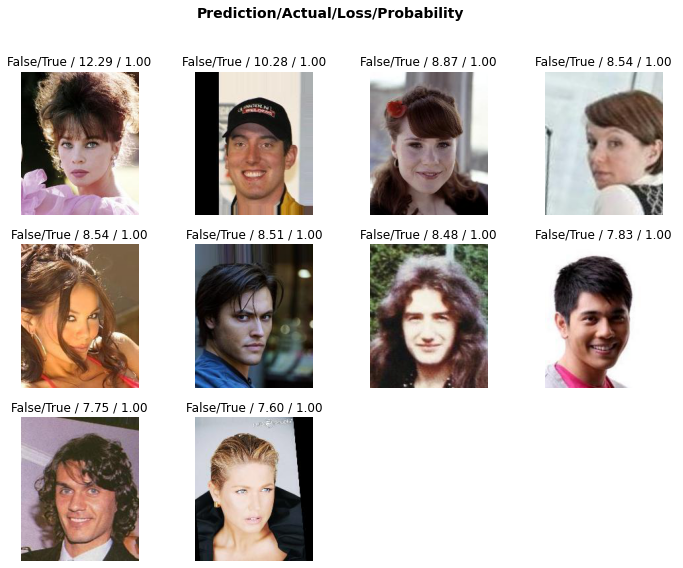

In [101]:
interp = Interpretation.from_learner(learn)
interp.plot_top_losses(10)

In [87]:
# learn.export(f"{os.getcwd()}/learners/5_o_Clock_Shadow.pkl")
learn.save(f"{os.getcwd()}/learners/Arched_Eyebrows.pth")


In [77]:
learn.save

'C:\\Users\\magnu\\OneDrive\\Dokumente\\Datathon_2022'

# Unzipping

In [5]:
import zipfile
with zipfile.ZipFile("archive2.zip", 'r') as zip_ref:
    zip_ref.extractall("all_images")

FileNotFoundError: [Errno 2] No such file or directory: 'archive2.zip'